KNN columns: ['dataset', 'missing_frac', 'imp_simple_mean', 'imp_simple_std', 'imp_weighted_mean', 'imp_weighted_std', 'imp_gower_mean', 'imp_gower_std', 'clf_original_mean', 'clf_original_std', 'clf_simple_mean', 'clf_simple_std', 'clf_weighted_mean', 'clf_weighted_std', 'clf_gower_mean', 'clf_gower_std']
MLP columns: ['dataset', 'missing_frac', 'imp_mlp_mean', 'imp_mlp_std', 'clf_original_mean', 'clf_original_std', 'clf_mlp_mean', 'clf_mlp_std', 'unnamed:_8', 'unnamed:_9', 'unnamed:_10', 'unnamed:_11']
RF columns: ['dataset', 'missing_frac', 'imp_rf_mean', 'imp_rf_std', 'clf_original_mean', 'clf_original_std', 'clf_rf_mean', 'clf_rf_std', 'unnamed:_8', 'unnamed:_9']


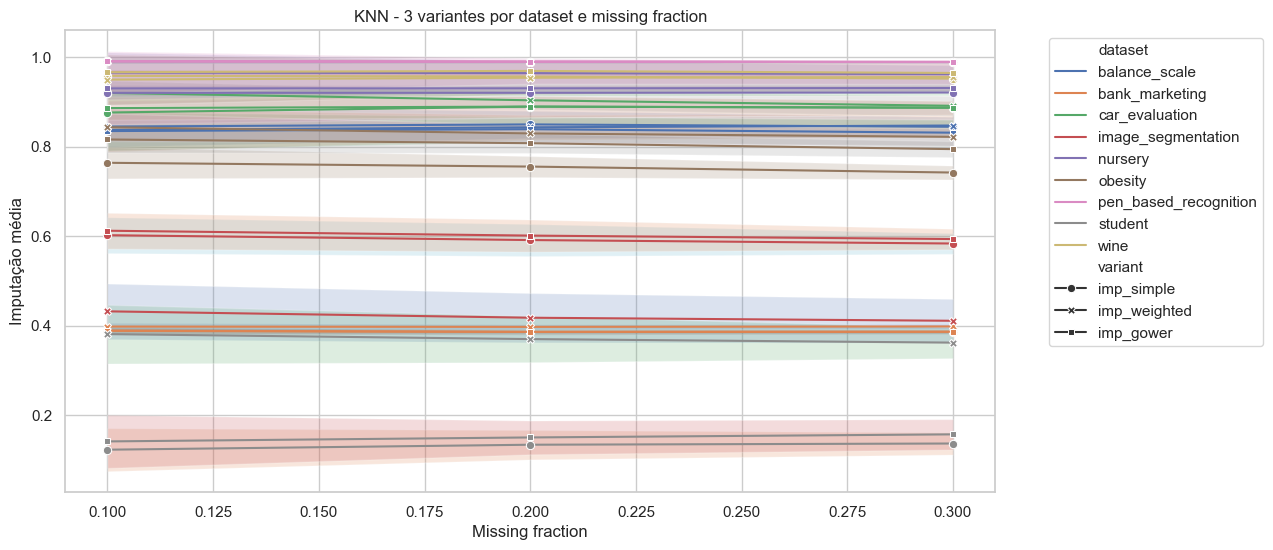

imp_mean_avg  imp_mean_std  \
variant      dataset        missing_frac                               
imp_gower    balance_scale  0.1               0.834884           NaN   
                            0.2               0.839080           NaN   
                            0.3               0.831298           NaN   
             bank_marketing 0.1               0.388717           NaN   
                            0.2               0.385843           NaN   
...                                                ...           ...   
imp_weighted student        0.2               0.369630           NaN   
                            0.3               0.361728           NaN   
             wine           0.1               0.950000           NaN   
                            0.2               0.954167           NaN   
                            0.3               0.955856           NaN   

                                          imp_std_avg  imp_std_std  
variant      dataset        missing_frac                            
imp_gower    balance_scale  0.1              0.043336          NaN  
                            0.2              0.028155          NaN  
                            0.3              0.029281          NaN  
             bank_marketing 0.1              0.007588          NaN  
                            0.2              0.004401          NaN  
...                                               ...          ...  
imp_weighted student        0.2              0.051618          NaN  
                            0.3              0.034748          NaN  
             wine           0.1              0.056222          NaN  
                            0.2              0.036864          NaN  
                            0.3              0.032123          NaN  

[81 rows x 4 columns]

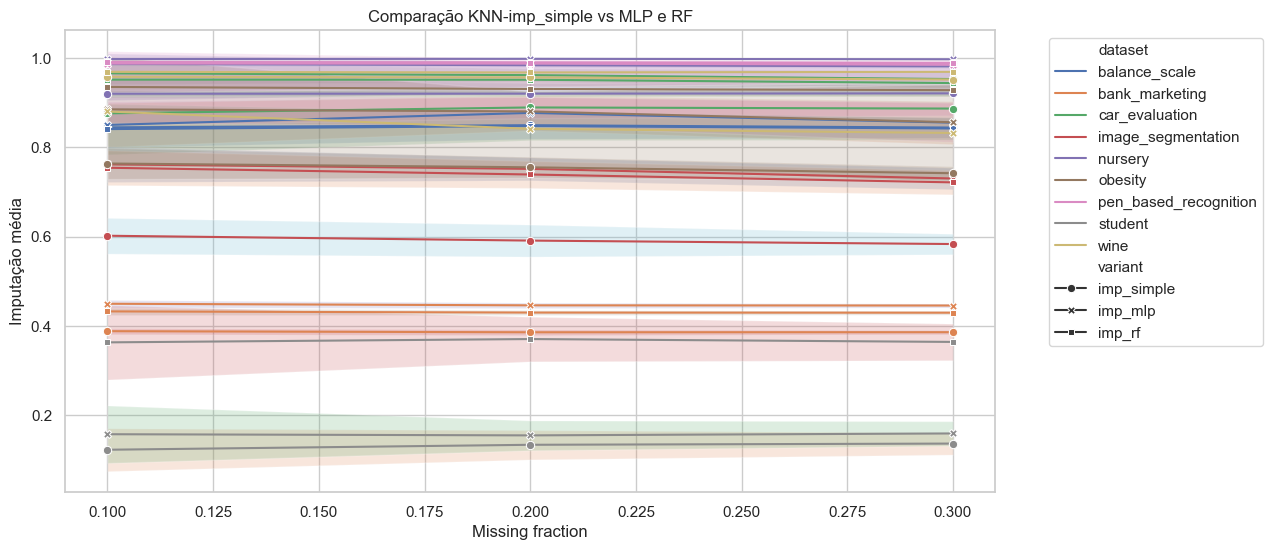

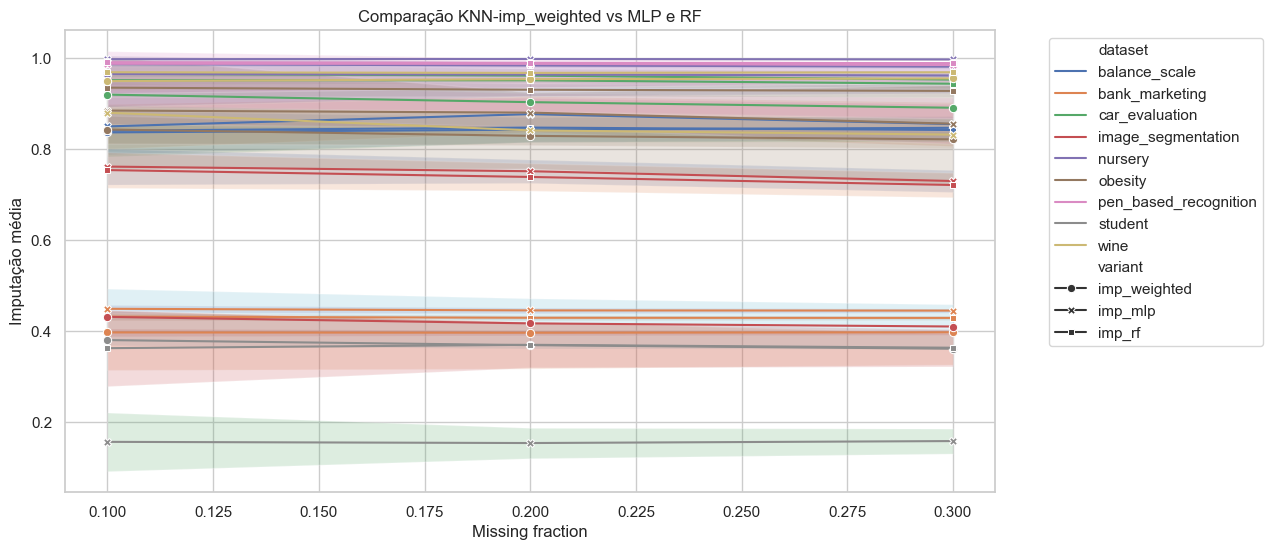

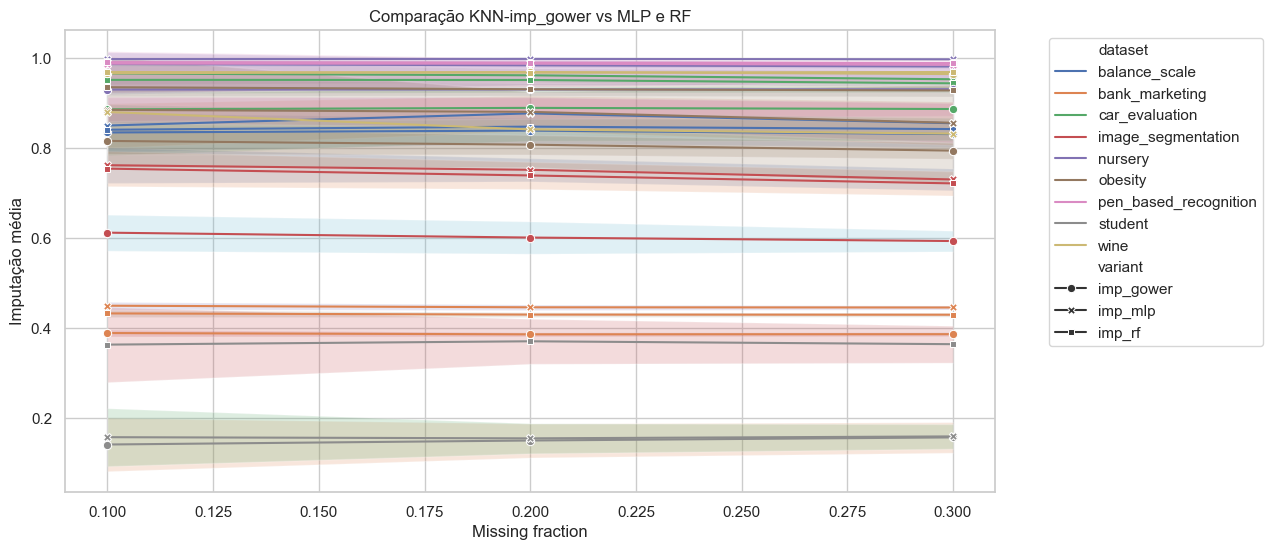

imp_mean_avg  imp_mean_std  \
method variant   dataset        missing_frac                               
KNN    imp_gower balance_scale  0.1               0.834884           NaN   
                                0.2               0.839080           NaN   
                                0.3               0.831298           NaN   
                 bank_marketing 0.1               0.388717           NaN   
                                0.2               0.385843           NaN   
...                                                    ...           ...   
RF     imp_rf    student        0.2               0.370370           NaN   
                                0.3               0.363951           NaN   
                 wine           0.1               0.969444           NaN   
                                0.2               0.968056           NaN   
                                0.3               0.969444           NaN   

                                              imp_std_avg  imp_std_std  
method variant   dataset        missing_frac                            
KNN    imp_gower balance_scale  0.1              0.043336          NaN  
                                0.2              0.028155          NaN  
                                0.3              0.029281          NaN  
                 bank_marketing 0.1              0.007588          NaN  
                                0.2              0.004401          NaN  
...                                                   ...          ...  
RF     imp_rf    student        0.2              0.050060          NaN  
                                0.3              0.041023          NaN  
                 wine           0.1              0.046338          NaN  
                                0.2              0.032244          NaN  
                                0.3              0.022306          NaN  

[135 rows x 4 columns]

In [30]:
# ---------------------------
# 0. Bibliotecas
# ---------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ---------------------------
# 1. Ler CSVs (ROBUSTO)
# ---------------------------
def read_summary(path):
    df = pd.read_csv(path, sep=None, engine="python")
    # se veio tudo em uma coluna, força split
    if len(df.columns) == 1 and ',' in df.columns[0]:
        df = pd.read_csv(path, sep=',', engine="python")
    return df

knn_df = read_summary('KNN.csv')
mlp_df = read_summary('MLP.csv')
rf_df  = read_summary('RF.csv')




# ---------------------------
# 2. Limpar colunas
# ---------------------------
def clean_columns(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    return df

knn_df = clean_columns(knn_df)
mlp_df = clean_columns(mlp_df)
rf_df  = clean_columns(rf_df)

# Checar colunas
print("KNN columns:", knn_df.columns.tolist())
print("MLP columns:", mlp_df.columns.tolist())
print("RF columns:", rf_df.columns.tolist())

# ---------------------------
# 3. Detectar colunas automaticamente
# ---------------------------
def get_imp_cols(df, method_prefix=''):
    mean_cols = [c for c in df.columns if c.startswith(f'imp_{method_prefix}') and c.endswith('_mean')]
    std_cols  = [c for c in df.columns if c.startswith(f'imp_{method_prefix}') and c.endswith('_std')]
    # Detectar id_vars automaticamente
    id_vars = [c for c in ['dataset','missing_frac'] if c in df.columns]
    if len(id_vars)<2:
        raise ValueError(f"Não encontrou as colunas 'dataset' e 'missing_frac'. Colunas disponíveis: {df.columns.tolist()}")
    return id_vars, mean_cols, std_cols

knn_id, knn_mean_cols, knn_std_cols = get_imp_cols(knn_df)
mlp_id, mlp_mean_cols, mlp_std_cols = get_imp_cols(mlp_df,'mlp')
rf_id, rf_mean_cols, rf_std_cols    = get_imp_cols(rf_df,'rf')

# ---------------------------
# 4. Função para criar long format
# ---------------------------
def long_format(df, id_vars, mean_cols, std_cols, method_name):
    # Melt mean
    long = pd.melt(
        df,
        id_vars=id_vars,
        value_vars=mean_cols,
        var_name='variant',
        value_name='imp_mean'
    )
    # Melt std
    std_long = pd.melt(
        df,
        id_vars=id_vars,
        value_vars=std_cols,
        var_name='variant_std',
        value_name='imp_std'
    )
    # Ajustar nomes para merge
    std_long['variant'] = std_long['variant_std'].str.replace('_std','')
    long['variant'] = long['variant'].str.replace('_mean','')
    long = long.merge(std_long[[*id_vars,'variant','imp_std']], on=[*id_vars,'variant'], how='left')
    long['method'] = method_name
    return long

# ---------------------------
# 5. Criar long formats
# ---------------------------
knn_long = long_format(knn_df, knn_id, knn_mean_cols, knn_std_cols, 'KNN')
mlp_long = long_format(mlp_df, mlp_id, mlp_mean_cols, mlp_std_cols, 'MLP')
rf_long  = long_format(rf_df, rf_id, rf_mean_cols, rf_std_cols, 'RF')

# ---------------------------
# 6. Função de gráfico
# ---------------------------
def plot_performance(df, title=None):
    plt.figure(figsize=(12,6))
    sns.lineplot(
        data=df,
        x='missing_frac',
        y='imp_mean',
        hue='dataset',
        style='variant',
        markers=True,
        dashes=False
    )
    for dataset in df['dataset'].unique():
        for variant in df['variant'].unique():
            sub = df[(df['dataset']==dataset) & (df['variant']==variant)]
            if not sub.empty:
                plt.fill_between(
                    sub['missing_frac'],
                    sub['imp_mean']-sub['imp_std'],
                    sub['imp_mean']+sub['imp_std'],
                    alpha=0.2
                )
    plt.title(title)
    plt.xlabel("Missing fraction")
    plt.ylabel("Imputação média")
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.show()

# ---------------------------
# 7. Análise individual de KNN
# ---------------------------
plot_performance(knn_long, title="KNN - 3 variantes por dataset e missing fraction")

knn_stats = knn_long.groupby(['variant','dataset','missing_frac']).agg(
    imp_mean_avg=('imp_mean','mean'),
    imp_mean_std=('imp_mean','std'),
    imp_std_avg=('imp_std','mean'),
    imp_std_std=('imp_std','std')
)
display(knn_stats)

# ---------------------------
# 8. Comparação KNN vs MLP e RF
# ---------------------------
def compare_knn_variant(knn_variant):
    knn_sub = knn_long[knn_long['variant']==knn_variant]
    comp_df = pd.concat([knn_sub, mlp_long, rf_long], ignore_index=True)
    plot_performance(comp_df, title=f"Comparação KNN-{knn_variant} vs MLP e RF")

for variant in knn_long['variant'].unique():
    compare_knn_variant(variant)

# ---------------------------
# 9. Estatísticas descritivas completas
# ---------------------------
all_long = pd.concat([knn_long, mlp_long, rf_long], ignore_index=True)
stats = all_long.groupby(['method','variant','dataset','missing_frac']).agg(
    imp_mean_avg=('imp_mean','mean'),
    imp_mean_std=('imp_mean','std'),
    imp_std_avg=('imp_std','mean'),
    imp_std_std=('imp_std','std')
)
display(stats)


In [32]:
def plot_knn_by_variant(knn_long, variant_name):
    sub = knn_long[knn_long['variant'] == variant_name]

    plt.figure(figsize=(12,6))
    sns.lineplot(
        data=sub,
        x='missing_frac',
        y='imp_mean',
        hue='dataset',
        markers=True,
        dashes=False
    )

    # Área de desvio padrão
    for dataset in sub['dataset'].unique():
        sub2 = sub[sub['dataset'] == dataset]
        if not sub2.empty:
            plt.fill_between(
                sub2['missing_frac'],
                sub2['imp_mean'] - sub2['imp_std'],
                sub2['imp_mean'] + sub2['imp_std'],
                alpha=0.2
            )

    plt.title(f"KNN – Variante {variant_name}")
    plt.xlabel("Missing fraction")
    plt.ylabel("Imputação média")
    plt.legend(title="Dataset", bbox_to_anchor=(1.05,1))
    plt.show()



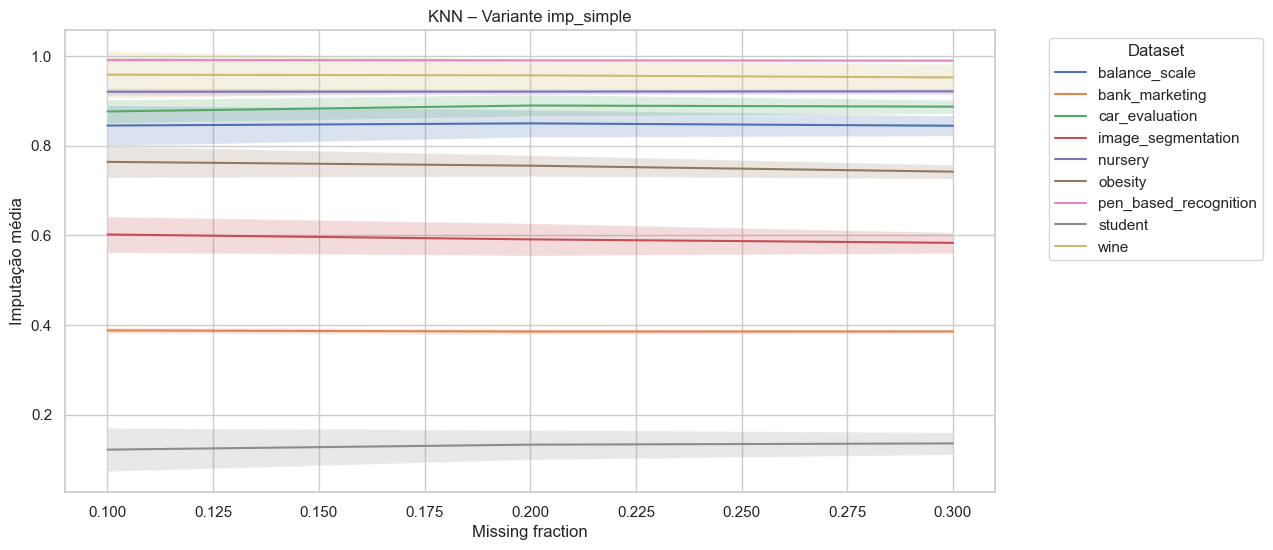

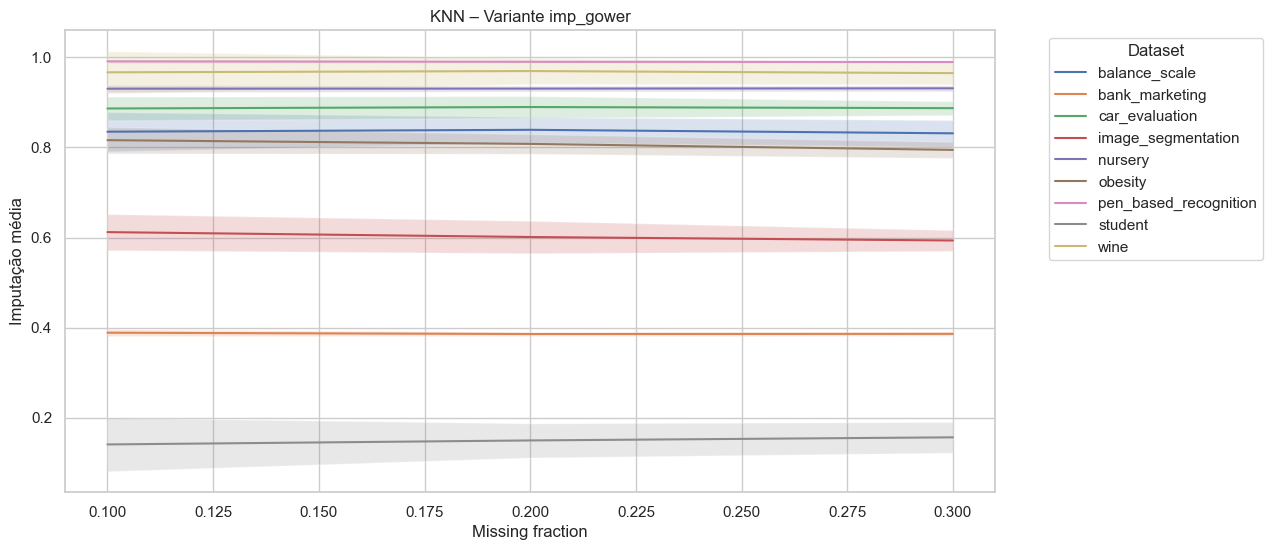

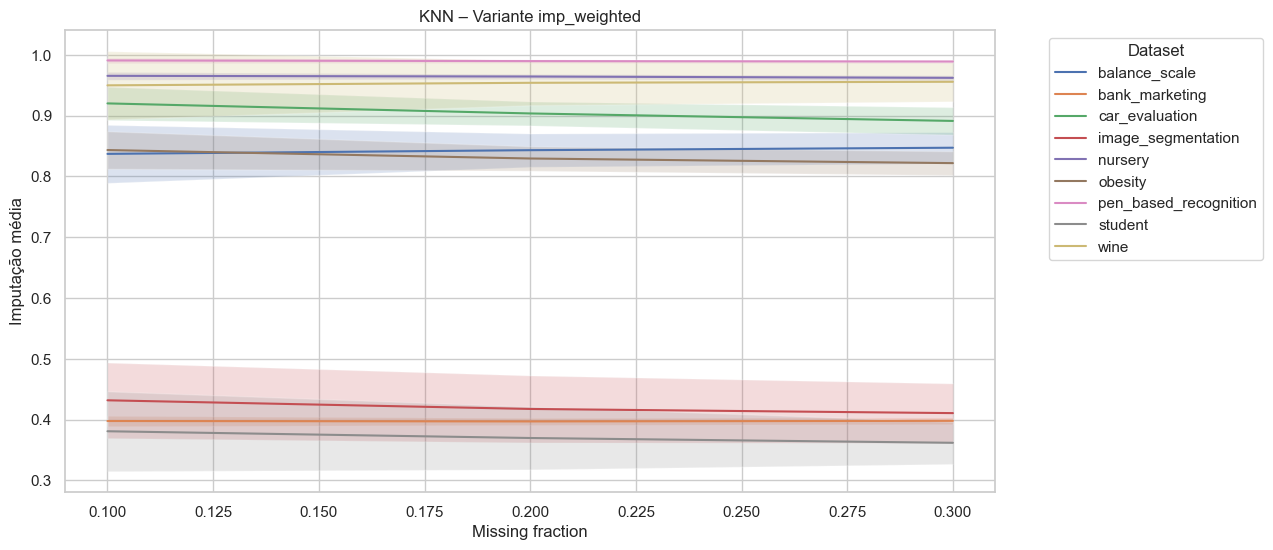

In [33]:
plot_knn_by_variant(knn_long, 'imp_simple')
plot_knn_by_variant(knn_long, 'imp_gower')
plot_knn_by_variant(knn_long, 'imp_weighted')


In [34]:
knn_stats = knn_long.groupby(
    ['variant','dataset','missing_frac']
).agg(
    imp_mean_avg=('imp_mean','mean'),
    imp_mean_std=('imp_mean','std'),
    imp_std_avg=('imp_std','mean'),
    imp_std_std=('imp_std','std')
)

display(knn_stats)


imp_mean_avg  imp_mean_std  \
variant      dataset        missing_frac                               
imp_gower    balance_scale  0.1               0.834884           NaN   
                            0.2               0.839080           NaN   
                            0.3               0.831298           NaN   
             bank_marketing 0.1               0.388717           NaN   
                            0.2               0.385843           NaN   
...                                                ...           ...   
imp_weighted student        0.2               0.369630           NaN   
                            0.3               0.361728           NaN   
             wine           0.1               0.950000           NaN   
                            0.2               0.954167           NaN   
                            0.3               0.955856           NaN   

                                          imp_std_avg  imp_std_std  
variant      dataset        missing_frac                            
imp_gower    balance_scale  0.1              0.043336          NaN  
                            0.2              0.028155          NaN  
                            0.3              0.029281          NaN  
             bank_marketing 0.1              0.007588          NaN  
                            0.2              0.004401          NaN  
...                                               ...          ...  
imp_weighted student        0.2              0.051618          NaN  
                            0.3              0.034748          NaN  
             wine           0.1              0.056222          NaN  
                            0.2              0.036864          NaN  
                            0.3              0.032123          NaN  

[81 rows x 4 columns]

In [20]:
def plot_performance_by_dataset(df, title_prefix=""):
    for dataset in df['dataset'].unique():
        plt.figure(figsize=(10,5))
        sub = df[df['dataset']==dataset]
        sns.lineplot(
            data=sub,
            x='missing_frac',
            y='imp_mean',
            hue='variant',
            style='method',
            markers=True,
            dashes=False
        )
        # Preencher desvio padrão
        for variant in sub['variant'].unique():
            for method in sub['method'].unique():
                sub2 = sub[(sub['variant']==variant) & (sub['method']==method)]
                if not sub2.empty:
                    plt.fill_between(sub2['missing_frac'],
                                     sub2['imp_mean']-sub2['imp_std'],
                                     sub2['imp_mean']+sub2['imp_std'],
                                     alpha=0.2)
        plt.title(f"{title_prefix} {dataset}")
        plt.ylabel("Imputação média")
        plt.xlabel("Missing fraction")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


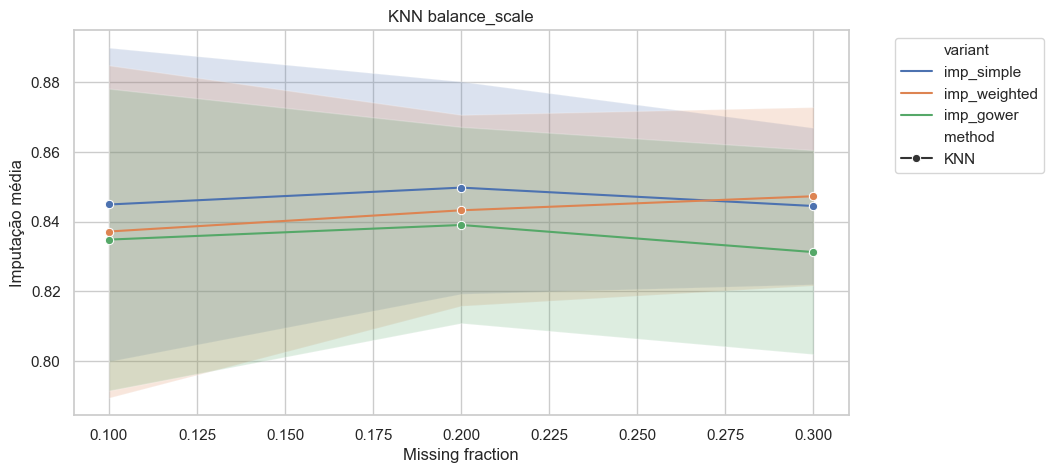

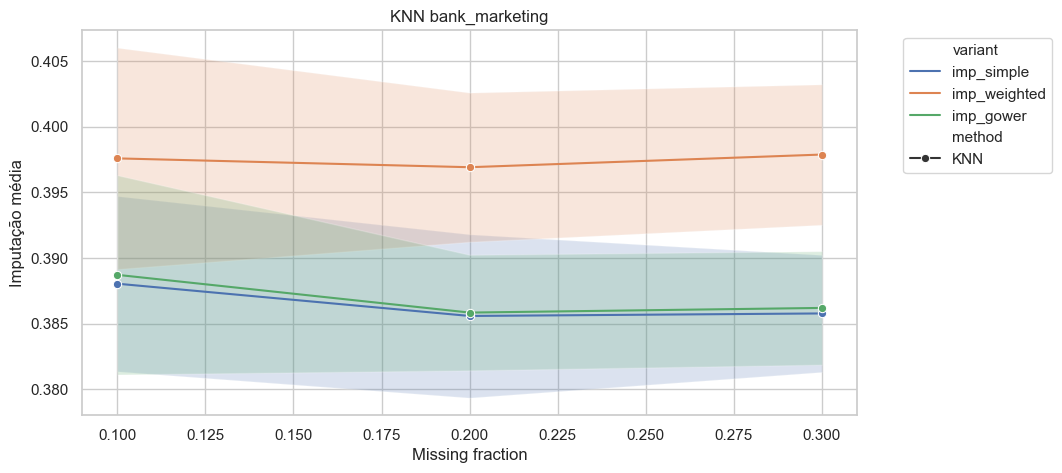

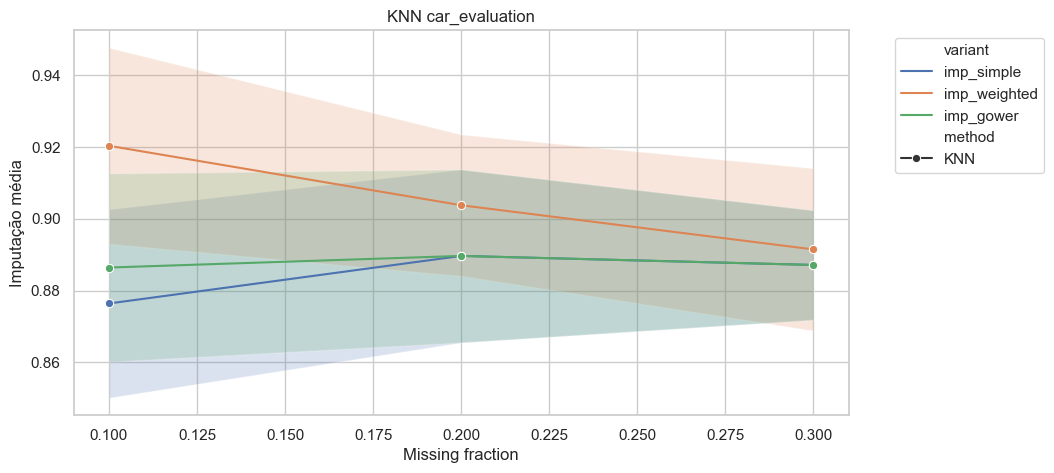

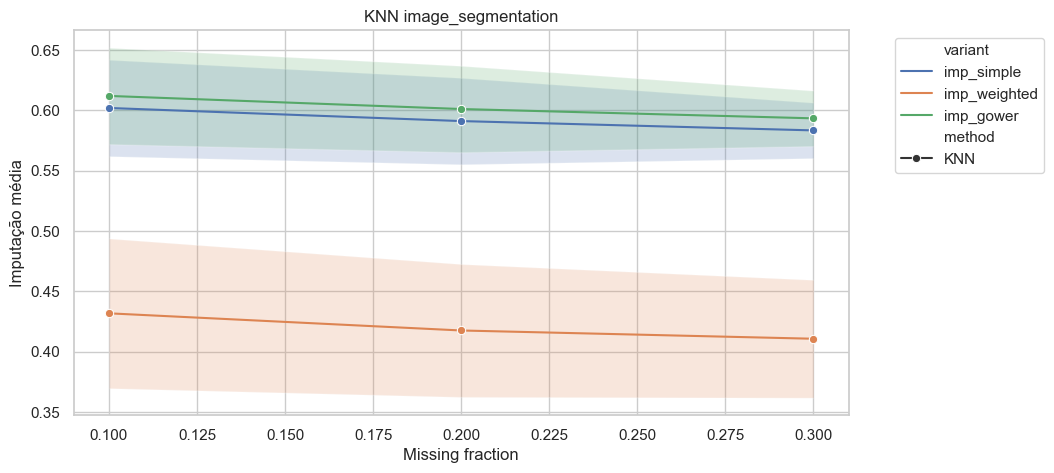

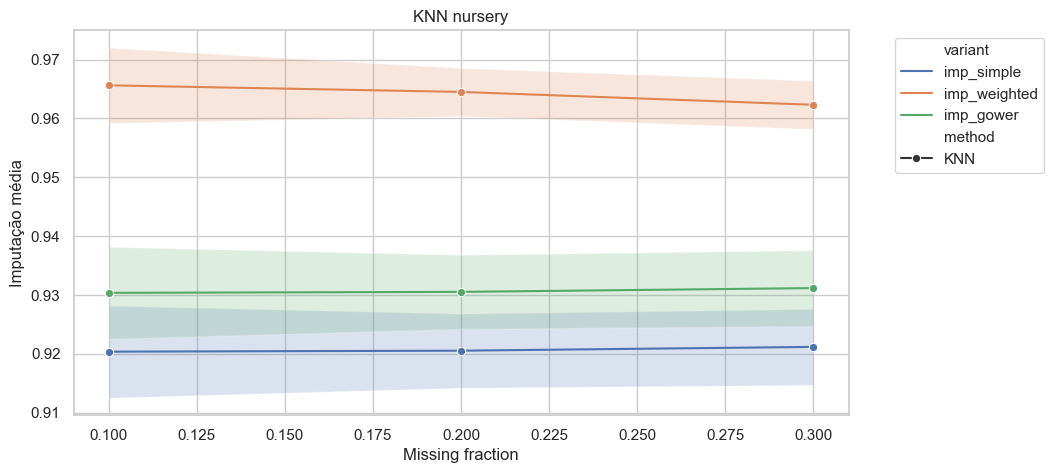

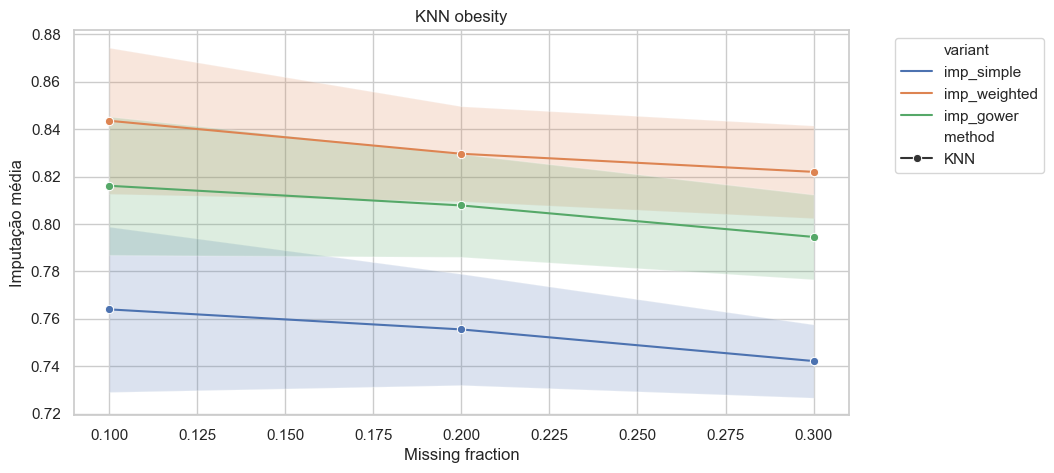

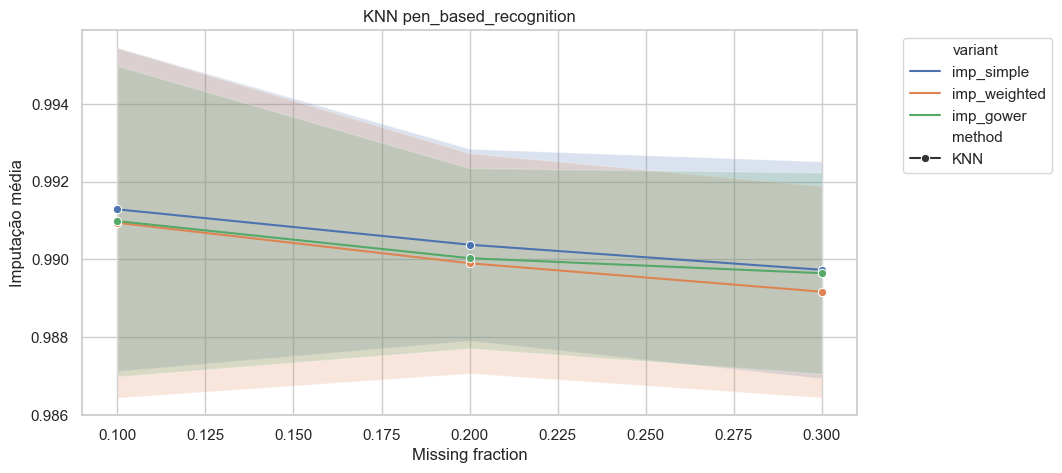

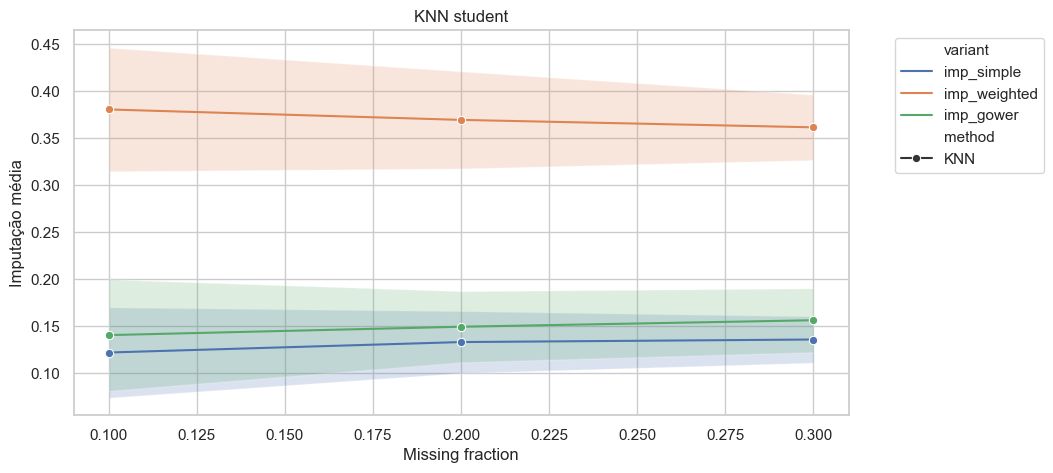

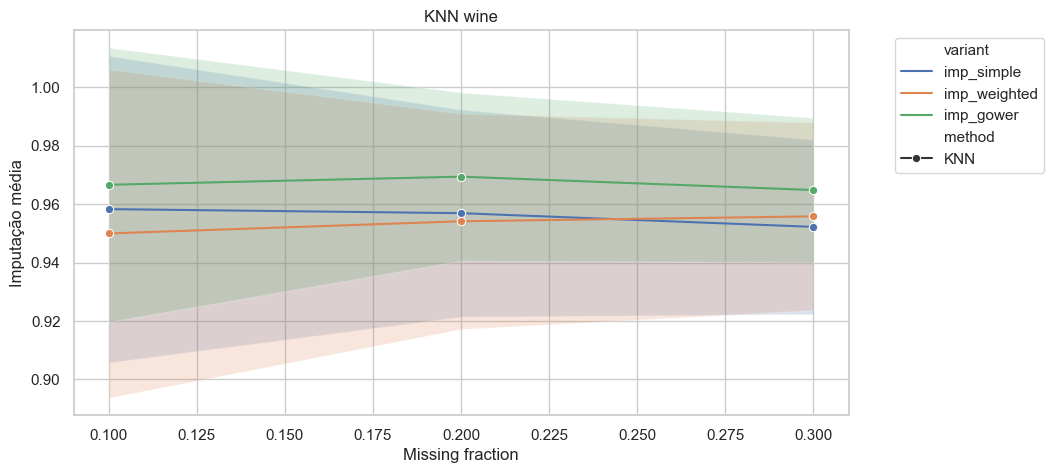

In [21]:
plot_performance_by_dataset(knn_long, title_prefix="KNN")


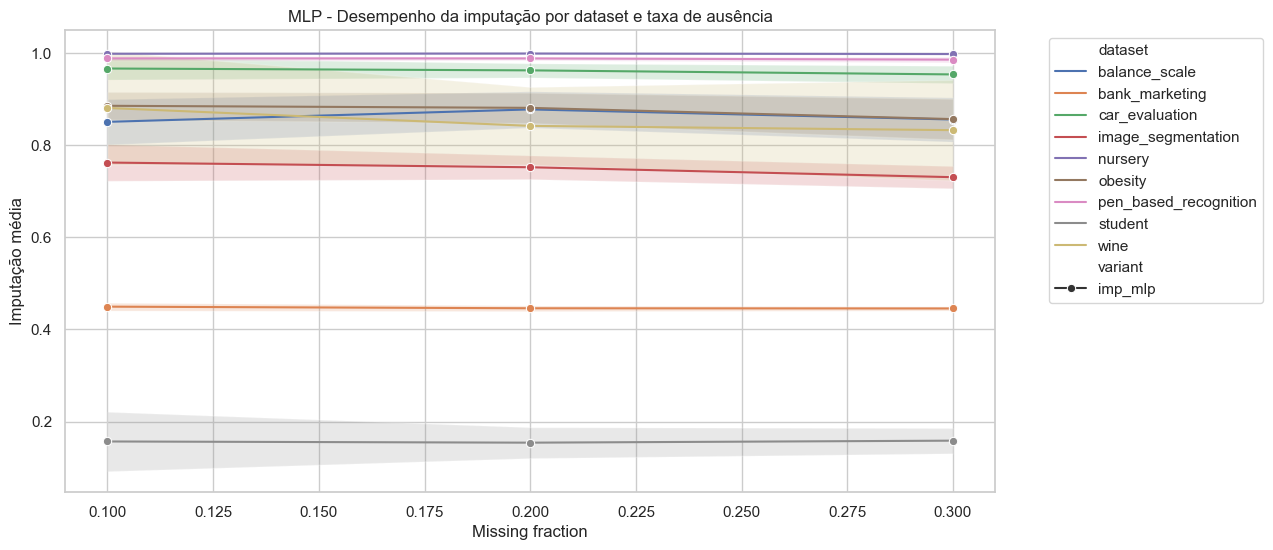

In [26]:
# ---------------------------
# Análise individual do MLP
# ---------------------------
plot_performance(
    mlp_long,
    title="MLP - Desempenho da imputação por dataset e taxa de ausência"
)


In [27]:
mlp_stats = mlp_long.groupby(
    ['variant','dataset','missing_frac']
).agg(
    imp_mean_avg=('imp_mean','mean'),
    imp_mean_std=('imp_mean','std'),
    imp_std_avg=('imp_std','mean'),
    imp_std_std=('imp_std','std')
)

display(mlp_stats)


imp_mean_avg  imp_mean_std  \
variant dataset               missing_frac                               
imp_mlp balance_scale         0.1               0.850388           NaN   
                              0.2               0.877395           NaN   
                              0.3               0.855471           NaN   
        bank_marketing        0.1               0.449505           NaN   
                              0.2               0.445989           NaN   
                              0.3               0.445559           NaN   
        car_evaluation        0.1               0.966111           NaN   
                              0.2               0.962102           NaN   
                              0.3               0.953315           NaN   
        image_segmentation    0.1               0.762112           NaN   
                              0.2               0.751909           NaN   
                              0.3               0.730378           NaN   
        nursery               0.1               0.998199           NaN   
                              0.2               0.998622           NaN   
                              0.3               0.997611           NaN   
        obesity               0.1               0.885261           NaN   
                              0.2               0.880791           NaN   
                              0.3               0.856358           NaN   
        pen_based_recognition 0.1               0.988036           NaN   
                              0.2               0.987993           NaN   
                              0.3               0.985384           NaN   
        student               0.1               0.157037           NaN   
                              0.2               0.154444           NaN   
                              0.3               0.158765           NaN   
        wine                  0.1               0.880556           NaN   
                              0.2               0.841667           NaN   
                              0.3               0.832407           NaN   

                                            imp_std_avg  imp_std_std  
variant dataset               missing_frac                            
imp_mlp balance_scale         0.1              0.049118          NaN  
                              0.2              0.039280          NaN  
                              0.3              0.047942          NaN  
        bank_marketing        0.1              0.008461          NaN  
                              0.2              0.006078          NaN  
                              0.3              0.004471          NaN  
        car_evaluation        0.1              0.023967          NaN  
                              0.2              0.015245          NaN  
                              0.3              0.018741          NaN  
        image_segmentation    0.1              0.039524          NaN  
                              0.2              0.025694          NaN  
                              0.3              0.024147          NaN  
        nursery               0.1              0.001953          NaN  
                              0.2              0.000979          NaN  
                              0.3              0.001963          NaN  
        obesity               0.1              0.029933          NaN  
                              0.2              0.032927          NaN  
                              0.3              0.044029          NaN  
        pen_based_recognition 0.1              0.005081          NaN  
                              0.2              0.003855          NaN  
                              0.3              0.005928          NaN  
        student               0.1              0.064441          NaN  
                              0.2              0.033442          NaN  
                              0.3              0.027420          NaN  
        wine                  0.1              0.12

In [28]:
def plot_mlp_by_dataset(df):
    for dataset in df['dataset'].unique():
        plt.figure(figsize=(10,5))
        sub = df[df['dataset'] == dataset]

        sns.lineplot(
            data=sub,
            x='missing_frac',
            y='imp_mean',
            hue='variant',
            markers=True,
            dashes=False
        )

        # Desvio padrão
        for variant in sub['variant'].unique():
            sub2 = sub[sub['variant'] == variant]
            if not sub2.empty:
                plt.fill_between(
                    sub2['missing_frac'],
                    sub2['imp_mean'] - sub2['imp_std'],
                    sub2['imp_mean'] + sub2['imp_std'],
                    alpha=0.2
                )

        plt.title(f"MLP – {dataset}")
        plt.xlabel("Missing fraction")
        plt.ylabel("Imputação média")
        plt.legend(title="Variante", bbox_to_anchor=(1.05,1))
        plt.show()


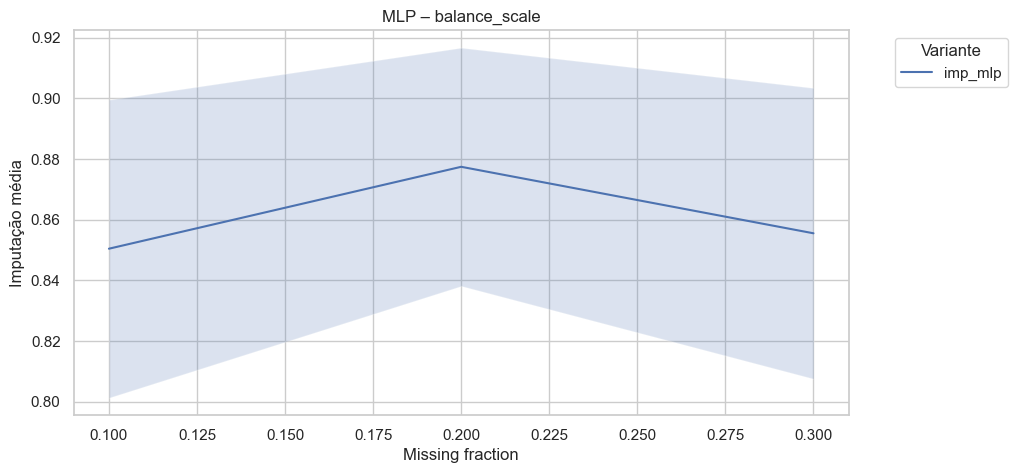

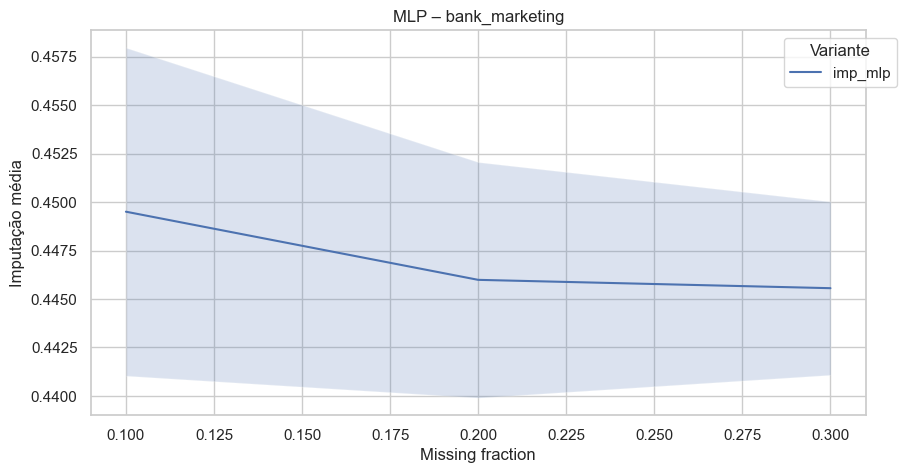

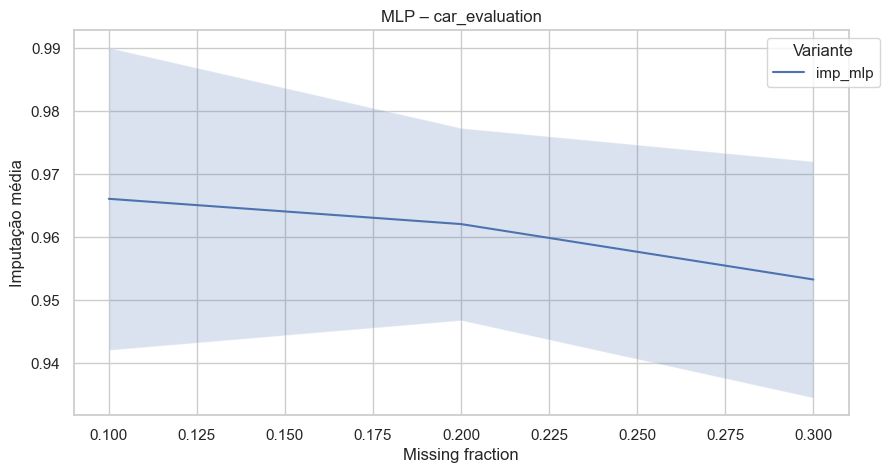

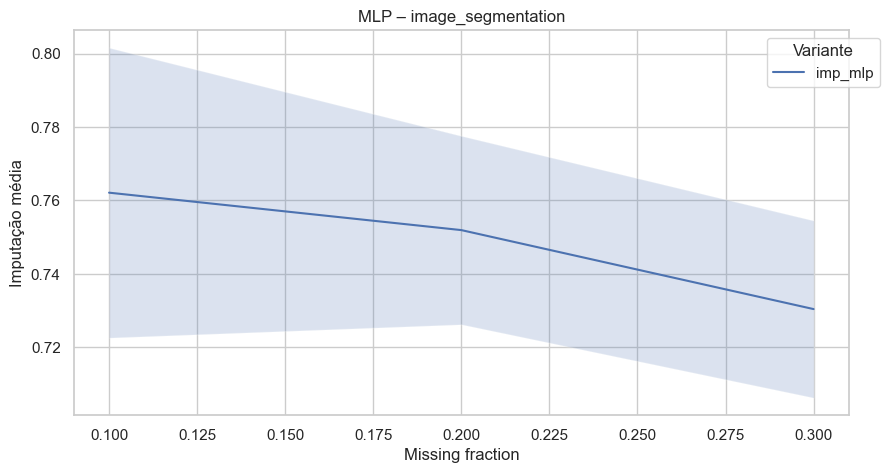

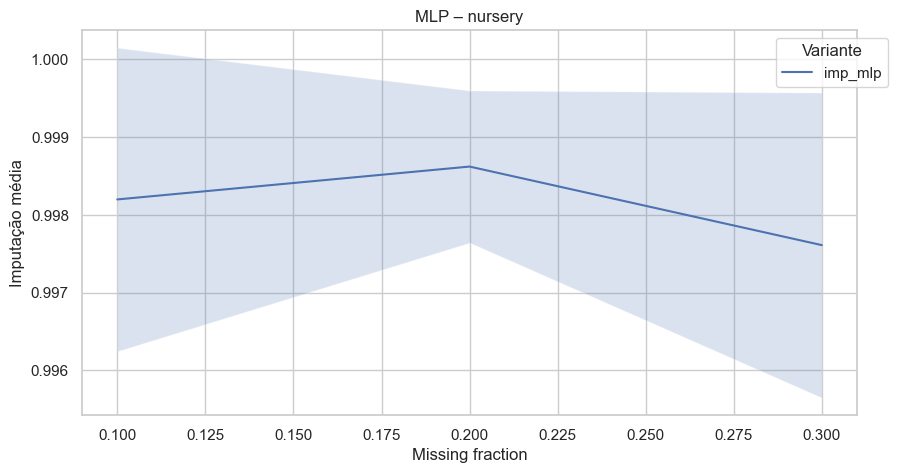

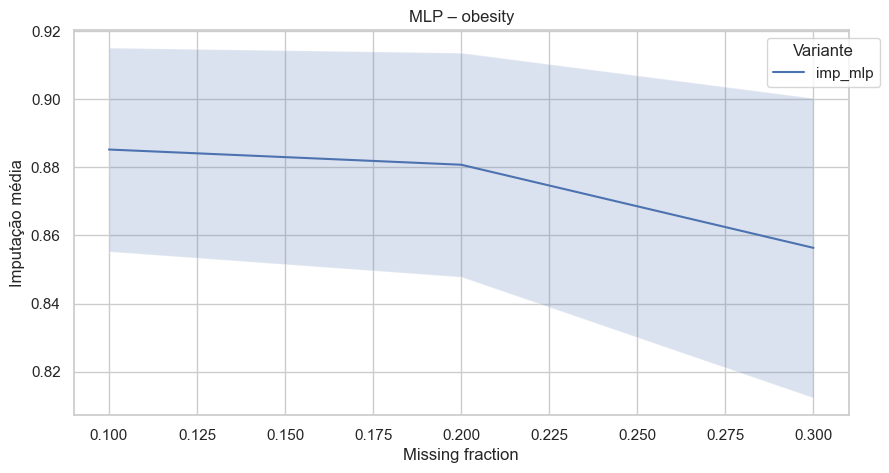

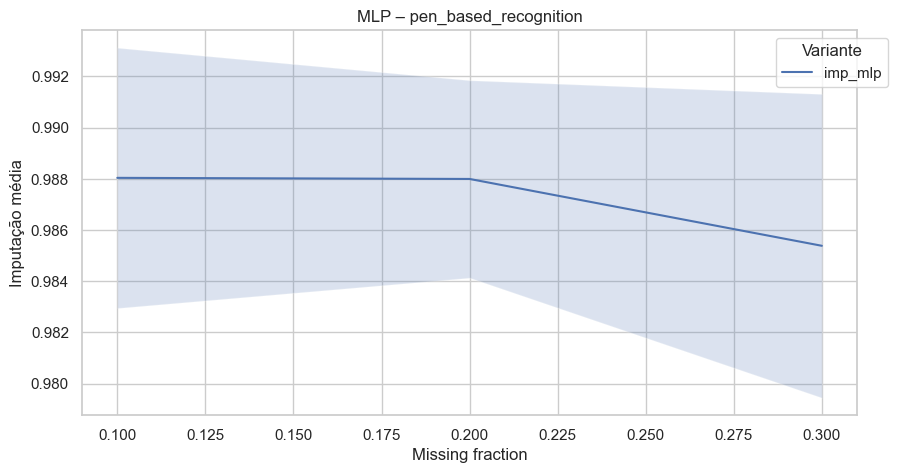

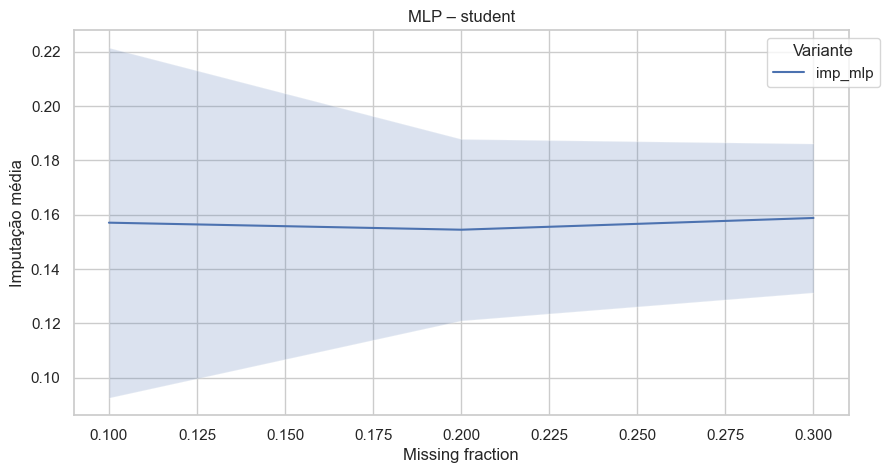

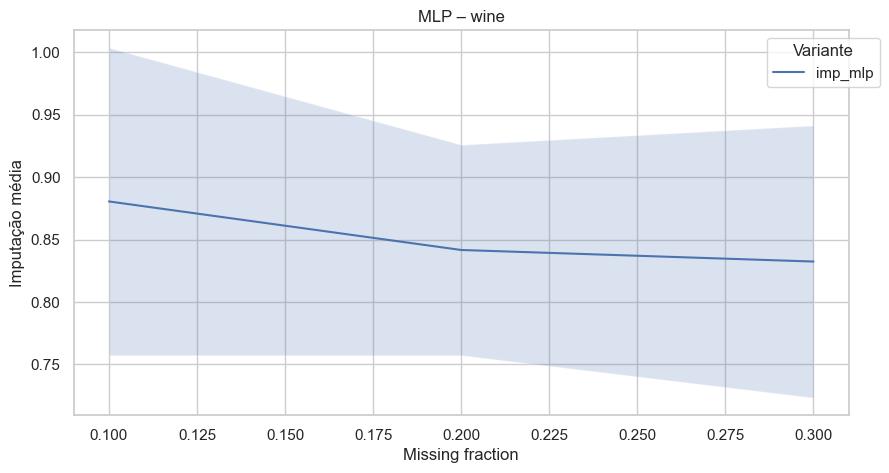

In [29]:
plot_mlp_by_dataset(mlp_long)


In [35]:
def plot_rf_by_variant(rf_long, variant_name):
    sub = rf_long[rf_long['variant'] == variant_name]

    plt.figure(figsize=(12,6))
    sns.lineplot(
        data=sub,
        x='missing_frac',
        y='imp_mean',
        hue='dataset',
        markers=True,
        dashes=False
    )

    # Área de desvio padrão
    for dataset in sub['dataset'].unique():
        sub2 = sub[sub['dataset'] == dataset]
        if not sub2.empty:
            plt.fill_between(
                sub2['missing_frac'],
                sub2['imp_mean'] - sub2['imp_std'],
                sub2['imp_mean'] + sub2['imp_std'],
                alpha=0.2
            )

    plt.title(f"Random Forest – Variante {variant_name}")
    plt.xlabel("Missing fraction")
    plt.ylabel("Imputação média")
    plt.legend(title="Dataset", bbox_to_anchor=(1.05,1))
    plt.show()


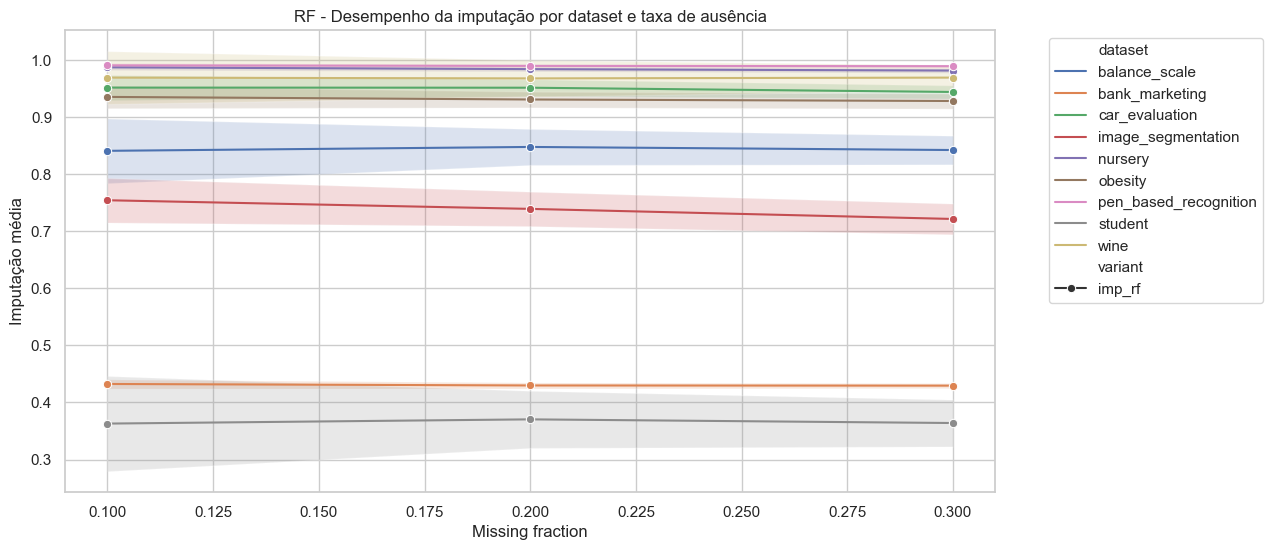

In [36]:
# ---------------------------
# Análise individual do RF
# ---------------------------
plot_performance(
    rf_long,
    title="RF - Desempenho da imputação por dataset e taxa de ausência"
)

In [37]:
rf_stats = rf_long.groupby(
    ['variant','dataset','missing_frac']
).agg(
    imp_mean_avg=('imp_mean','mean'),
    imp_mean_std=('imp_mean','std'),
    imp_std_avg=('imp_std','mean'),
    imp_std_std=('imp_std','std')
)

display(rf_stats)


imp_mean_avg  imp_mean_std  \
variant dataset               missing_frac                               
imp_rf  balance_scale         0.1               0.841085           NaN   
                              0.2               0.847893           NaN   
                              0.3               0.842494           NaN   
        bank_marketing        0.1               0.432396           NaN   
                              0.2               0.429794           NaN   
                              0.3               0.429489           NaN   
        car_evaluation        0.1               0.951944           NaN   
                              0.2               0.951729           NaN   
                              0.3               0.944291           NaN   
        image_segmentation    0.1               0.754451           NaN   
                              0.2               0.739319           NaN   
                              0.3               0.721649           NaN   
        nursery               0.1               0.987431           NaN   
                              0.2               0.984307           NaN   
                              0.3               0.981808           NaN   
        obesity               0.1               0.935601           NaN   
                              0.2               0.931073           NaN   
                              0.3               0.928442           NaN   
        pen_based_recognition 0.1               0.990941           NaN   
                              0.2               0.989965           NaN   
                              0.3               0.989500           NaN   
        student               0.1               0.362963           NaN   
                              0.2               0.370370           NaN   
                              0.3               0.363951           NaN   
        wine                  0.1               0.969444           NaN   
                              0.2               0.968056           NaN   
                              0.3               0.969444           NaN   

                                            imp_std_avg  imp_std_std  
variant dataset               missing_frac                            
imp_rf  balance_scale         0.1              0.056664          NaN  
                              0.2              0.031613          NaN  
                              0.3              0.025157          NaN  
        bank_marketing        0.1              0.008024          NaN  
                              0.2              0.005260          NaN  
                              0.3              0.004363          NaN  
        car_evaluation        0.1              0.022068          NaN  
                              0.2              0.014760          NaN  
                              0.3              0.011541          NaN  
        image_segmentation    0.1              0.039002          NaN  
                              0.2              0.030219          NaN  
                              0.3              0.026960          NaN  
        nursery               0.1              0.004538          NaN  
                              0.2              0.003827          NaN  
                              0.3              0.003808          NaN  
        obesity               0.1              0.019792          NaN  
                              0.2              0.013829          NaN  
                              0.3              0.013389          NaN  
        pen_based_recognition 0.1              0.004091          NaN  
                              0.2              0.003358          NaN  
                              0.3              0.002999          NaN  
        student               0.1              0.083421          NaN  
                              0.2              0.050060          NaN  
                              0.3              0.041023          NaN  
        wine                  0.1              0.04

In [38]:
def plot_rf_by_dataset(df):
    for dataset in df['dataset'].unique():
        plt.figure(figsize=(10,5))
        sub = df[df['dataset'] == dataset]

        sns.lineplot(
            data=sub,
            x='missing_frac',
            y='imp_mean',
            hue='variant',
            markers=True,
            dashes=False
        )

        # Desvio padrão
        for variant in sub['variant'].unique():
            sub2 = sub[sub['variant'] == variant]
            if not sub2.empty:
                plt.fill_between(
                    sub2['missing_frac'],
                    sub2['imp_mean'] - sub2['imp_std'],
                    sub2['imp_mean'] + sub2['imp_std'],
                    alpha=0.2
                )

        plt.title(f"RF – {dataset}")
        plt.xlabel("Missing fraction")
        plt.ylabel("Imputação média")
        plt.legend(title="Variante", bbox_to_anchor=(1.05,1))
        plt.show()


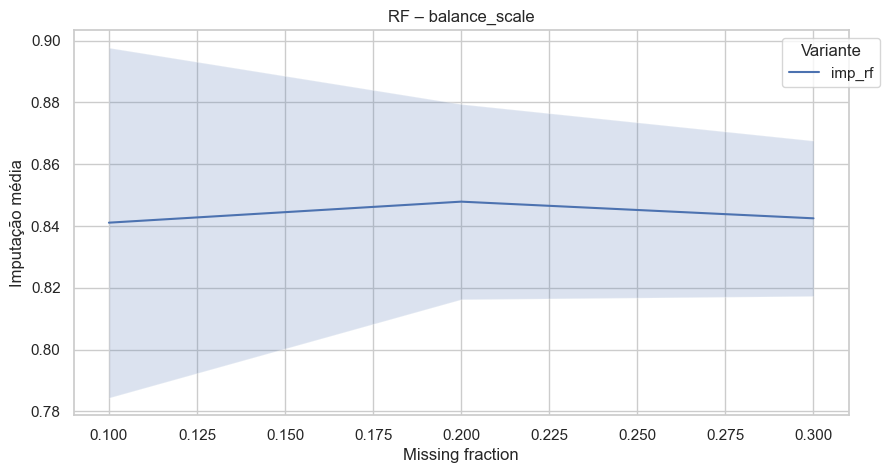

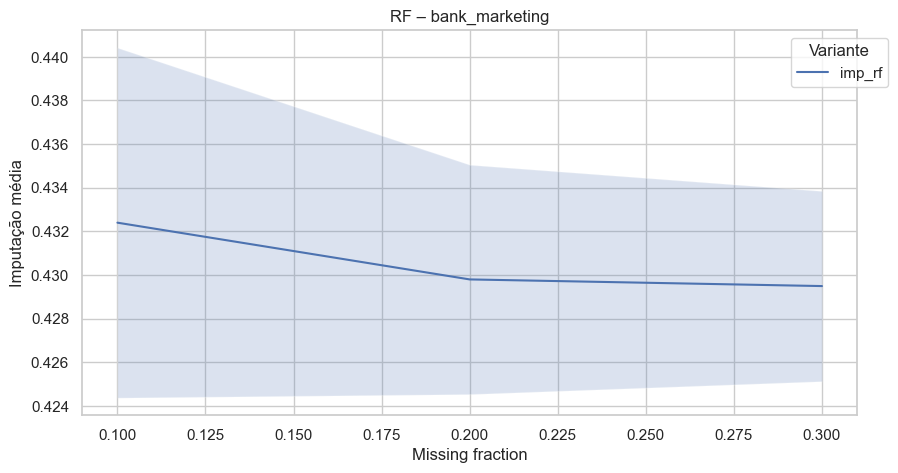

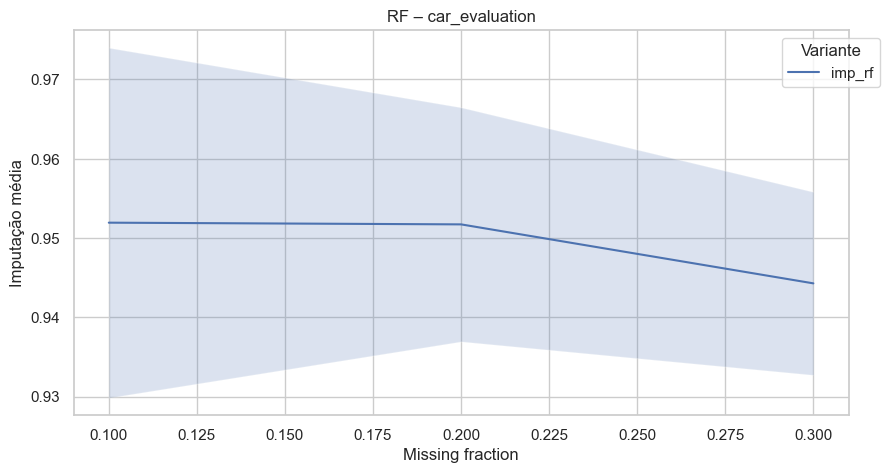

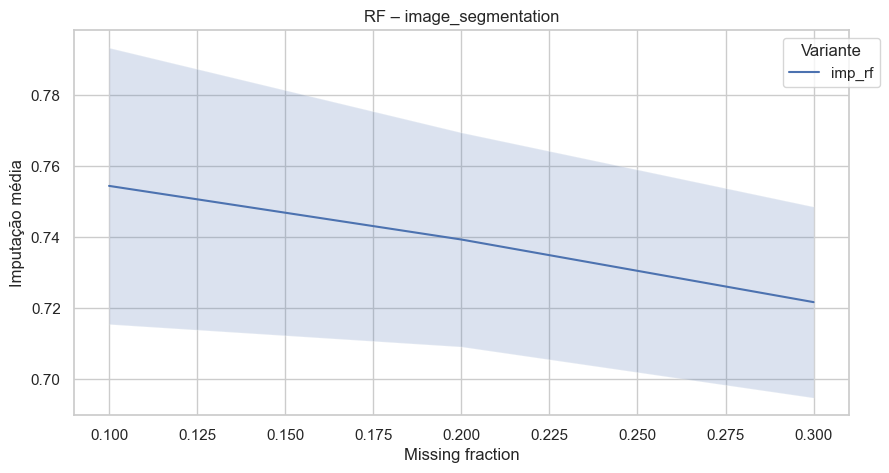

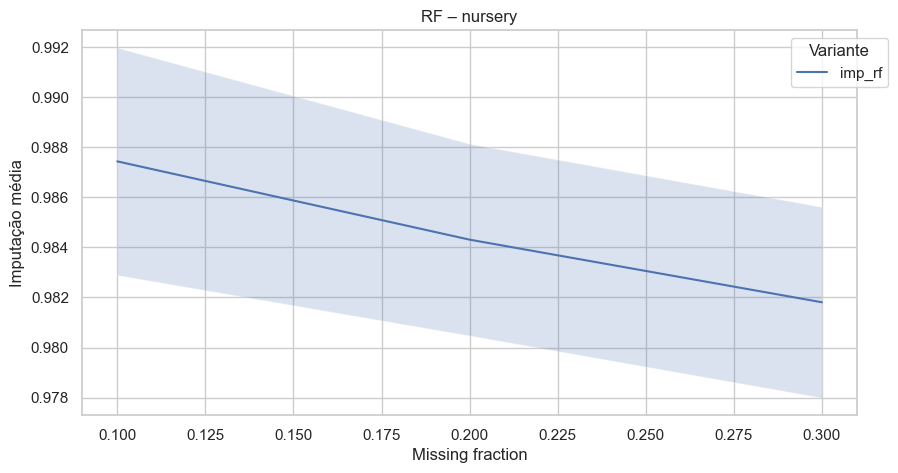

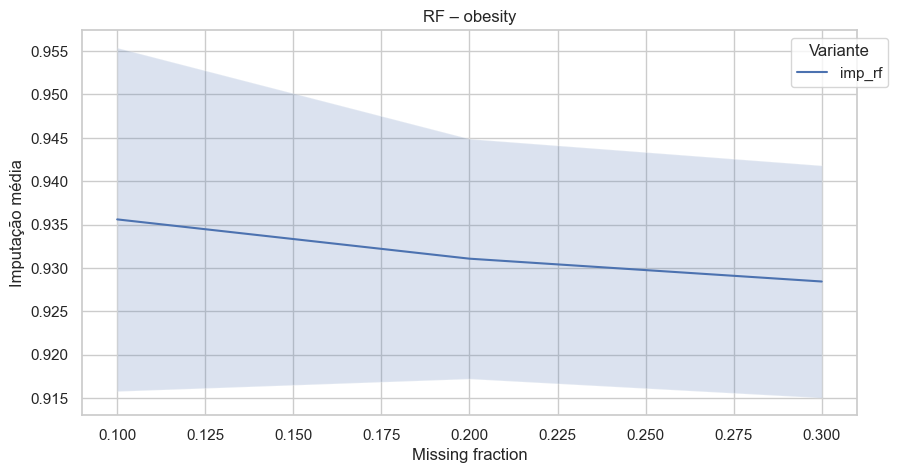

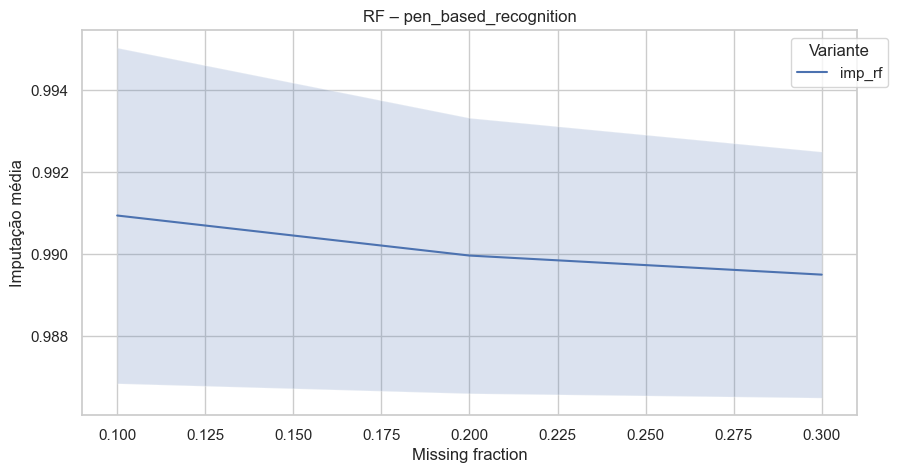

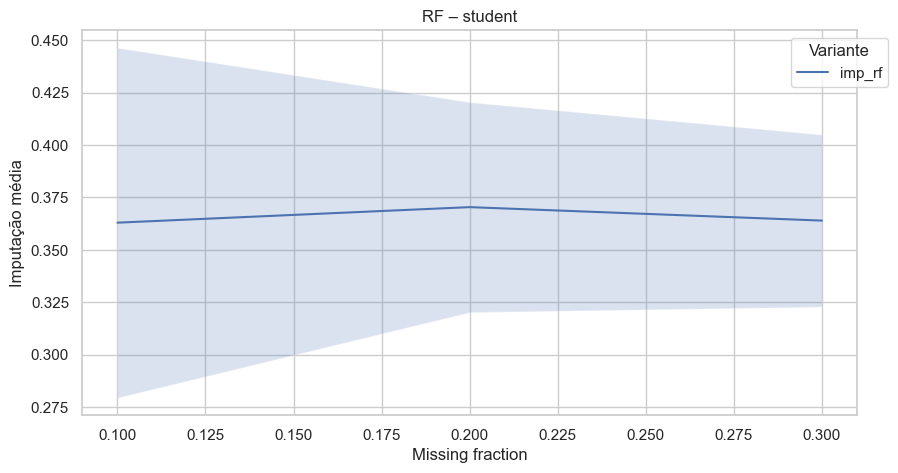

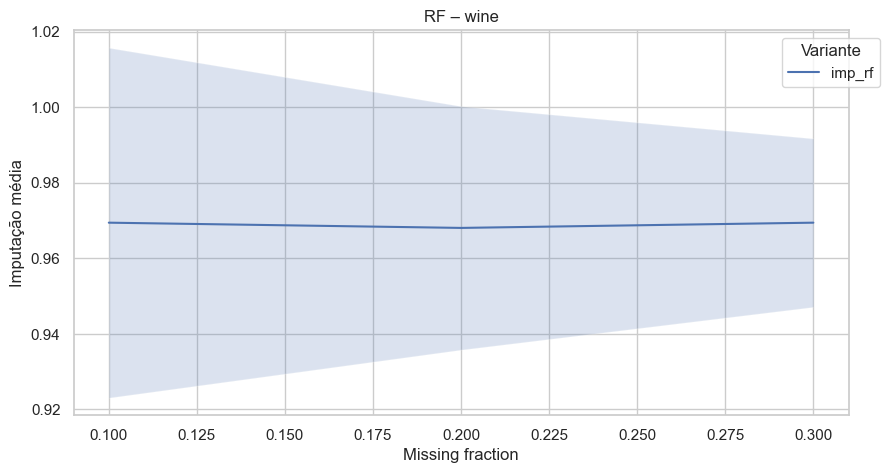

In [39]:
plot_rf_by_dataset(rf_long)